In [ ]:
from google.colab import drive  
drive.mount('/content/drive')    

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install heartpy
# !pip3 install openpyxl --upgrade 
# !pip install --upgrade tf_siren  

     |████████████████████████████████| 1.0 MB 5.4 MB/s 


In [ ]:
cd /content/drive/MyDrive/SNN_Project 

/content/drive/MyDrive/SNN_Project


Method 1: Direct 12Hz prediction

In [ ]:
import torch
import pandas as pd
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, TensorDataset, Dataset
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

Read Data- Normal or Abnormal 

In [ ]:
import glob
import os
import numpy as np
sixhz_signal = list()
twelvehz_signal = list()
labels = list()
sixhzsignal = pd.DataFrame({})
twelvehzsignal = pd.DataFrame({})
labels = list()


folder_path = "/content/drive/MyDrive/SNN_Project/ANN Upsampling Project Data"
all_csvs = glob.glob("/content/drive/MyDrive/SNN_Project/ANN Upsampling Project Data/*.csv") # Read ALL csv files
all_csvs.sort(key=lambda k:int(k.split("/")[-1][-5]))
for i in range(1, 4):
    twelvehz_normal = pd.read_csv(os.path.join(folder_path, f"6hznormal{i}.csv")).transpose()
    sixhz_normal = pd.read_csv(os.path.join(folder_path, f"12hznormal{i}.csv")).transpose()
    twelvehz_abnormal = pd.read_csv(os.path.join(folder_path, f"6hzabnormal{i}.csv")).transpose()
    sixhz_abnormal = pd.read_csv(os.path.join(folder_path, f"12hzabnormal{i}.csv")).transpose()
    if twelvehz_normal.shape[0] < sixhz_normal.shape[0]:
        sixhz_normal = sixhz_normal.iloc[0: twelvehz_normal.shape[0]]
    else:
        twelvehz_normal = twelvehz_normal.iloc[0: sixhz_normal.shape[0]]

    if twelvehz_abnormal.shape[0] < sixhz_abnormal.shape[0]:
        sixhz_abnormal = sixhz_abnormal.iloc[0: twelvehz_abnormal.shape[0]]
    else:
        twelvehz_abnormal = twelvehz_abnormal.iloc[0: sixhz_abnormal.shape[0]]
    if i == 1:
        sixhz_abnormal = sixhz_abnormal.iloc[0:0]
        twelvehz_abnormal = twelvehz_abnormal.iloc[0:0]
    twelvehzsignal = pd.concat([twelvehzsignal, sixhz_normal, sixhz_abnormal])
    sixhzsignal = pd.concat([sixhzsignal, twelvehz_normal, twelvehz_abnormal])
    labels.extend([1] * sixhz_normal.shape[0])
    labels.extend([0] * sixhz_abnormal.shape[0])
input_signal = sixhzsignal.to_numpy()
output_signal = twelvehzsignal.to_numpy()
labels = np.array(labels)
print(f"Abnormal Signals - {np.sum(labels==0)}")
print(f"Normal Signals - {np.sum(labels==1)}")

print(input_signal.shape, output_signal.shape, labels.shape)

Abnormal Signals - 165
Normal Signals - 874
(1039, 113) (1039, 52) (1039,)


In [ ]:
D=pd.DataFrame(output_signal)
# D
D.to_csv('12.csv',index=False,header=False) 

Finding Ground truths (Heart rate)

In [ ]:
!pip install heartpy

In [ ]:
import torch
import glob2
import pandas as pd
import os
import heartpy as hp
HR=[]
D=pd.read_csv('12.csv',header=None)
for i in range(0,D.shape[0]): 
  working_data,measures=hp.process(D.iloc[i,:].values,12,calc_freq=True)
  HR.append(measures['bpm'])
len(HR)
Output_HR=pd.DataFrame(HR)
Output_HR.to_csv('12_gt.csv',index=False,header=False)

/usr/local/lib/python3.7/dist-packages/heartpy/analysis.py:522: UserWarning: Short signal.

---------Warning:---------
too few peak-peak intervals for (reliable) frequency domain measure computation, frequency output measures are still computed but treat them with caution!

HF is usually computed over a minimum of 1 minute of good signal. LF is usually computed over a minimum of 2 minutes of good signal.VLF is usually computed over a minimum of 5 minutes of good signal.The LF/HF ratio is usually computed over minimum 24 hours, although an absolute minimum of 5 min has also been suggested.

For more info see: 
Shaffer, F., Ginsberg, J.P. (2017), An Overview of Heart Rate Variability Metrics and Norms.

Task Force of Pacing and Electrophysiology (1996), Heart Rate Variability, in: European Heart Journal, vol.17, issue 3, pp354-381

This warning will not repeat
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/numpy/ma/core.py:5244: RuntimeWarning: Mean of empty sli

Prediction_model

In [ ]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import CuDNNLSTM, Dense, Dropout, LSTM
import pandas as pd
import torch
import glob2
import pandas as pd
import os

In [ ]:
pwd

'/content/drive/MyDrive/SNN_Project'

In [ ]:
import pandas as pd
import numpy as np
from numpy import mean 
D=pd.read_csv('12.csv',header=None)
Y=pd.read_csv('12_gt.csv',header=None)
Y[0].fillna(value=Y[0].mean(), inplace=True)
from sklearn.model_selection import train_test_split
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(D, Y, test_size = 0.2, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(D, Y, test_size = 0.2, random_state = 0)
X_train

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
627,0.003966,0.30643,0.527130,0.789560,0.060581,0.150050,0.13234,0.25946,0.46960,0.57976,...,0.58511,0.004924,0.156020,0.187580,0.24822,0.479150,0.116470,0.058052,0.157350,0.090677
1034,0.126840,0.17077,0.421140,0.413700,0.574260,0.744180,0.91575,0.31946,0.14333,0.24832,...,0.18526,0.069032,0.199250,0.189320,0.27161,0.393280,0.472520,0.568990,0.030999,0.097349
812,0.325700,0.23872,0.384160,0.602830,0.747720,0.777130,0.00101,0.16550,0.29743,0.22706,...,0.86620,0.033097,0.167680,0.281850,0.26007,0.008264,0.082903,0.384650,0.618150,0.814220
670,0.116470,0.15700,0.289430,0.480950,0.088053,0.040436,0.18654,0.20963,0.35856,0.52727,...,0.35180,0.023556,0.131740,0.207050,0.35131,0.633270,0.766270,0.211680,0.006402,0.129090
707,0.536260,0.74047,0.419250,0.002169,0.172960,0.233420,0.34806,0.57816,0.78074,0.68981,...,0.77647,1.000000,0.193440,0.079477,0.33246,0.700350,0.551920,0.007224,0.137330,0.233790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,0.126840,0.17077,0.421140,0.413700,0.574260,0.744180,0.91575,0.31946,0.14333,0.24832,...,0.18526,0.069032,0.199250,0.189320,0.27161,0.393280,0.472520,0.568990,0.030999,0.097349
763,0.722950,0.93979,0.219360,0.141130,0.760470,0.623320,0.00000,0.15051,0.24022,0.34161,...,0.15842,0.287620,0.313840,0.538560,0.73504,0.839290,0.109900,0.146650,0.287640,0.237710
835,0.751330,0.79832,0.019453,0.215610,0.405460,0.363640,0.59261,0.77396,0.64844,0.02596,...,0.64526,0.000045,0.153730,0.267980,0.30554,0.384370,0.646690,0.878370,1.000000,0.323980
559,0.538550,0.71665,0.974180,0.179960,0.276540,0.459100,0.33194,0.56032,0.69637,0.92423,...,0.21177,0.000000,0.030321,0.129480,0.20518,0.676190,0.841720,0.171500,0.069797,0.487050


In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout 
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import CuDNNLSTM, Dense, Dropout, LSTM
import pandas as pd
import torch
import glob2
import pandas as pd
import os

In [ ]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
627,0.003966,0.30643,0.527130,0.789560,0.060581,0.150050,0.13234,0.25946,0.46960,0.57976,...,0.58511,0.004924,0.156020,0.187580,0.24822,0.479150,0.116470,0.058052,0.157350,0.090677
1034,0.126840,0.17077,0.421140,0.413700,0.574260,0.744180,0.91575,0.31946,0.14333,0.24832,...,0.18526,0.069032,0.199250,0.189320,0.27161,0.393280,0.472520,0.568990,0.030999,0.097349
812,0.325700,0.23872,0.384160,0.602830,0.747720,0.777130,0.00101,0.16550,0.29743,0.22706,...,0.86620,0.033097,0.167680,0.281850,0.26007,0.008264,0.082903,0.384650,0.618150,0.814220
670,0.116470,0.15700,0.289430,0.480950,0.088053,0.040436,0.18654,0.20963,0.35856,0.52727,...,0.35180,0.023556,0.131740,0.207050,0.35131,0.633270,0.766270,0.211680,0.006402,0.129090
707,0.536260,0.74047,0.419250,0.002169,0.172960,0.233420,0.34806,0.57816,0.78074,0.68981,...,0.77647,1.000000,0.193440,0.079477,0.33246,0.700350,0.551920,0.007224,0.137330,0.233790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,0.126840,0.17077,0.421140,0.413700,0.574260,0.744180,0.91575,0.31946,0.14333,0.24832,...,0.18526,0.069032,0.199250,0.189320,0.27161,0.393280,0.472520,0.568990,0.030999,0.097349
763,0.722950,0.93979,0.219360,0.141130,0.760470,0.623320,0.00000,0.15051,0.24022,0.34161,...,0.15842,0.287620,0.313840,0.538560,0.73504,0.839290,0.109900,0.146650,0.287640,0.237710
835,0.751330,0.79832,0.019453,0.215610,0.405460,0.363640,0.59261,0.77396,0.64844,0.02596,...,0.64526,0.000045,0.153730,0.267980,0.30554,0.384370,0.646690,0.878370,1.000000,0.323980
559,0.538550,0.71665,0.974180,0.179960,0.276540,0.459100,0.33194,0.56032,0.69637,0.92423,...,0.21177,0.000000,0.030321,0.129480,0.20518,0.676190,0.841720,0.171500,0.069797,0.487050


In [140]:
#using nyqest frequency signal+filtered signal(12Hz )
from tf_siren import SinusodialRepresentationDense
from tf_siren import SIRENModel
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation
def sine(x):
    return tf.math.sin(x)
get_custom_objects().update({'sine':Activation(sine)})
regressor1 = Sequential()
regressor1.add(SinusodialRepresentationDense(53,input_dim=X_train.shape[1], kernel_initializer='he_uniform',activation='sine',kernel_regularizer=l2(0.01),activity_regularizer=l2(0.01)))
regressor1.add(Dropout(0.1))
regressor1.add(SinusodialRepresentationDense(25, kernel_initializer='he_uniform',activation='sine'))
regressor1.add(Dropout(0.1))
regressor1.add(Dense(1, kernel_initializer='he_uniform',activation='linear'))

In [141]:
# Nyqest frequency signal(12 hz)
import numpy as np
import matplotlib.pyplot as plt 
from scipy.signal import find_peaks
regressor1.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam',metrics=['mae','mse','mape'])
# Fitting the ANN to the Training set
history=regressor1.fit(X_train, y_train,validation_data=(X_val, y_val) ,batch_size = 32, epochs = 1000)
test_loss = regressor1.evaluate(X_test,y_test)

Epoch 1/1000
26/26 [==============================] - 1s 11ms/step - loss: 13773.8047 - mae: 107.5800 - mse: 13772.5615 - mape: 98.2225 - val_loss: 13746.3740 - val_mae: 106.6417 - val_mse: 13745.0986 - val_mape: 95.3304
Epoch 2/1000
26/26 [==============================] - 0s 3ms/step - loss: 12979.1553 - mae: 103.8513 - mse: 12977.8545 - mape: 94.4257 - val_loss: 13379.9941 - val_mae: 104.8795 - val_mse: 13378.6816 - val_mape: 93.5321
Epoch 3/1000
26/26 [==============================] - 0s 3ms/step - loss: 12766.2539 - mae: 102.8116 - mse: 12764.9414 - mape: 93.3567 - val_loss: 13194.8760 - val_mae: 104.0001 - val_mse: 13193.5693 - val_mape: 92.6503
Epoch 4/1000
26/26 [==============================] - 0s 3ms/step - loss: 12593.4033 - mae: 101.9679 - mse: 12592.1016 - mape: 92.4986 - val_loss: 13024.4834 - val_mae: 103.1757 - val_mse: 13023.1875 - val_mape: 91.8180
Epoch 5/1000
26/26 [==============================] - 0s 3ms/step - loss: 12448.5996 - mae: 101.2441 - mse: 12447.3154 

final metrics: training:loss=153.87, mae:9.49,mse: 150.92, mape: 9.6885 
test: loss=261.3, mae:9.68, mse:258.35, mape:11.28

Saving the predictor model of HRV

In [142]:
tf.keras.models.save_model(regressor1,'hrv_pred_mod1') 

INFO:tensorflow:Assets written to: hrv_pred_mod1/assets


INFO:tensorflow:Assets written to: hrv_pred_mod1/assets


Method2: 12Hz reconstructed signal 

In [147]:
import torch
import pandas as pd
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, TensorDataset, Dataset
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

Read data

In [148]:
import glob
import os
import numpy as np
sixhz_signal = list()
twelvehz_signal = list()
labels = list()
sixhzsignal = pd.DataFrame({})
twelvehzsignal = pd.DataFrame({})
labels = list()


folder_path = "/content/drive/MyDrive/SNN_Project/ANN Upsampling Project Data"
all_csvs = glob.glob("/content/drive/MyDrive/SNN_Project/ANN Upsampling Project Data/*.csv") # Read ALL csv files
all_csvs.sort(key=lambda k:int(k.split("/")[-1][-5]))
for i in range(1, 4):
    twelvehz_normal = pd.read_csv(os.path.join(folder_path, f"6hznormal{i}.csv")).transpose()
    sixhz_normal = pd.read_csv(os.path.join(folder_path, f"12hznormal{i}.csv")).transpose()
    twelvehz_abnormal = pd.read_csv(os.path.join(folder_path, f"6hzabnormal{i}.csv")).transpose()
    sixhz_abnormal = pd.read_csv(os.path.join(folder_path, f"12hzabnormal{i}.csv")).transpose()
    if twelvehz_normal.shape[0] < sixhz_normal.shape[0]:
        sixhz_normal = sixhz_normal.iloc[0: twelvehz_normal.shape[0]]
    else:
        twelvehz_normal = twelvehz_normal.iloc[0: sixhz_normal.shape[0]]

    if twelvehz_abnormal.shape[0] < sixhz_abnormal.shape[0]:
        sixhz_abnormal = sixhz_abnormal.iloc[0: twelvehz_abnormal.shape[0]]
    else:
        twelvehz_abnormal = twelvehz_abnormal.iloc[0: sixhz_abnormal.shape[0]]
    if i == 1:
        sixhz_abnormal = sixhz_abnormal.iloc[0:0]
        twelvehz_abnormal = twelvehz_abnormal.iloc[0:0]
    twelvehzsignal = pd.concat([twelvehzsignal, sixhz_normal, sixhz_abnormal])
    sixhzsignal = pd.concat([sixhzsignal, twelvehz_normal, twelvehz_abnormal])
    labels.extend([1] * sixhz_normal.shape[0])
    labels.extend([0] * sixhz_abnormal.shape[0])
input_signal = sixhzsignal.to_numpy()
output_signal = twelvehzsignal.to_numpy()
labels = np.array(labels)
print(f"Abnormal Signals - {np.sum(labels==0)}")
print(f"Normal Signals - {np.sum(labels==1)}")

print(input_signal.shape, output_signal.shape, labels.shape)

Abnormal Signals - 165
Normal Signals - 874
(1039, 113) (1039, 52) (1039,)


Step 1: Network Architecture

In [ ]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, n_inp_features, n_output_features):
        super(NeuralNetwork,self).__init__()

        self.layer1 = nn.Linear(n_inp_features, 500)
        self.dropout1 = nn.Dropout(p=0.25)
        self.layer2 = nn.Linear(500, 700)
        self.dropout2 = nn.Dropout(p=0.25)
        self.layer3 = nn.Linear(700, n_output_features)
        # self.layer3 = nn.Linear(num_input_features, 10)
    def forward(self,x):
        x=self.layer1(x)
        # x = self.dropout1(x)
        # x =(x)
        x = torch.relu(x)
        x = self.layer2(x)
        # x = self.dropout2(x)
        x = torch.relu(x)
        x = self.layer3(x)
        return x 

In [ ]:
class SignalDatset(Dataset):
    def __init__(self, input_signal, output_signal, labels, transform):
        self.input_signal = input_signal
        self.output_signal = output_signal
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        inp_sig = torch.from_numpy(self.input_signal[index])
        op_sig = torch.from_numpy(self.output_signal[index])
        label = self.labels[index]
        return inp_sig, op_sig, label

    def __len__(self):
        return self.input_signal.shape[0]

In [ ]:
# Data definition
torch.manual_seed(1)
full_dataset = SignalDatset(input_signal, output_signal, labels, transforms.ToTensor())
train_set, val_set, test_set = random_split(full_dataset, [650, 194, 195])

# Data Loaders
train_loader = DataLoader(train_set, shuffle=True, batch_size = 32)
val_loader = DataLoader(val_set, shuffle=True, batch_size = 32)
test_loader = DataLoader(test_set, batch_size = len(test_set))

# Loss Functiin
loss_func = torch.nn.MSELoss()

In [ ]:
ann_upsampler = NeuralNetwork(input_signal.shape[1], output_signal.shape[1])
optimizer = optim.SGD(ann_upsampler.parameters(), lr=0.5, weight_decay=5e-5)
NUM_EPOCHS = 2000
# Training Loop
for epoch in range(0, NUM_EPOCHS):
  train_loss = 0.0
  for inp, op, labels in train_loader:
      optimizer.zero_grad()
      pred = ann_upsampler(inp.float())
      loss = loss_func(pred, op.float())
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
  val_loss = 0.0
  with torch.no_grad():
     for inp, op, labels in val_loader:
         pred = ann_upsampler(inp.float())
         loss = loss_func(pred, op.float())
         val_loss += loss.item()
     print(f"Epoch - {epoch}, train loss - {train_loss/len(train_loader)*1.0:.5f}, val loss - {val_loss/len(val_loader)*1.0:.5f}")

Epoch - 0, train loss - 0.07954, val loss - 0.05541
Epoch - 1, train loss - 0.05122, val loss - 0.04573
Epoch - 2, train loss - 0.04454, val loss - 0.04347
Epoch - 3, train loss - 0.03812, val loss - 0.03691
Epoch - 4, train loss - 0.03342, val loss - 0.03101
Epoch - 5, train loss - 0.02972, val loss - 0.02890
Epoch - 6, train loss - 0.02703, val loss - 0.02629
Epoch - 7, train loss - 0.02495, val loss - 0.02308
Epoch - 8, train loss - 0.02349, val loss - 0.02241
Epoch - 9, train loss - 0.02199, val loss - 0.02150
Epoch - 10, train loss - 0.02072, val loss - 0.01965
Epoch - 11, train loss - 0.01971, val loss - 0.01921
Epoch - 12, train loss - 0.01901, val loss - 0.01936
Epoch - 13, train loss - 0.01802, val loss - 0.01867
Epoch - 14, train loss - 0.01707, val loss - 0.01717
Epoch - 15, train loss - 0.01641, val loss - 0.01606
Epoch - 16, train loss - 0.01567, val loss - 0.01655
Epoch - 17, train loss - 0.01484, val loss - 0.01547
Epoch - 18, train loss - 0.01429, val loss - 0.01473
Epo

In [ ]:
with torch.no_grad():
  for test_inp, test_op, labels in test_loader:
      pred = ann_upsampler(test_inp.float())
      mse = loss_func(pred, test_op.float())
print(f"Test MSE - {mse}") 

Test MSE - 0.0016630159225314856


Using the trained ANN_Sampler model to predict 12Hz reconstructed signal

In [ ]:
tr_l = DataLoader(train_set, batch_size = len(train_set))
v_l = DataLoader(val_set, batch_size = len(val_set))
te_l = DataLoader(test_set, batch_size = len(test_set))

In [ ]:
for inp1,op1,l1 in tr_l:
  pred1=ann_upsampler(inp1.float())
for inp2,op2,l2 in te_l:
  pred2=ann_upsampler(inp2.float())
for inp3,op3,l3 in v_l:
  pred3=ann_upsampler(inp3.float())
pred1.shape
out_ten = torch.cat((pred1,pred2,pred3), 0) #Concatenate 3 prediction results to get a single data output
out_ten.shape 

torch.Size([1039, 52])

In [ ]:
import torch
import pandas as pd
px=pd.DataFrame(out_ten.detach().numpy())
px
px.to_csv('12hz_reconst.csv',index=False,header=False) 

saving the reconstructor pytorch model

In [ ]:
torch.save(ann_upsampler,'/content/drive/MyDrive/SNN_Project/reconstructor.pt')

Finding Ground Truths (Heart Rates)

In [ ]:
import torch
import glob2
import pandas as pd
import os
import heartpy as hp
HR=[]
D=pd.read_csv('12hz_reconst.csv',header=None)
for i in range(0,D.shape[0]):
  working_data,measures=hp.process(D.iloc[i,:].values,12,calc_freq=True)
  HR.append(measures['bpm'])
len(HR)
Output_HR=pd.DataFrame(HR)
Output_HR.to_csv('12_reconst_gt.csv',index=False,header=False)

/usr/local/lib/python3.7/dist-packages/heartpy/analysis.py:522: UserWarning: Short signal.

---------Warning:---------
too few peak-peak intervals for (reliable) frequency domain measure computation, frequency output measures are still computed but treat them with caution!

HF is usually computed over a minimum of 1 minute of good signal. LF is usually computed over a minimum of 2 minutes of good signal.VLF is usually computed over a minimum of 5 minutes of good signal.The LF/HF ratio is usually computed over minimum 24 hours, although an absolute minimum of 5 min has also been suggested.

For more info see: 
Shaffer, F., Ginsberg, J.P. (2017), An Overview of Heart Rate Variability Metrics and Norms.

Task Force of Pacing and Electrophysiology (1996), Heart Rate Variability, in: European Heart Journal, vol.17, issue 3, pp354-381

This warning will not repeat
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/numpy/ma/core.py:5244: RuntimeWarning: Mean of empty sli

Prediction Model

In [150]:
import pandas as pd
import numpy as np
from numpy import mean 
D=pd.read_csv('12hz_reconst.csv',header=None)
Y=pd.read_csv('12_reconst_gt.csv',header=None)
Y[0].fillna(value=Y[0].mean(), inplace=True)
from sklearn.model_selection import train_test_split
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(D, Y, test_size = 0.2, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(D, Y, test_size = 0.2, random_state = 0)
X_train

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
627,0.195561,0.361920,0.466903,0.614139,0.841808,0.022798,0.067269,0.234260,0.278282,0.472232,...,0.019125,0.190220,0.207487,0.318803,0.532806,0.330500,0.547672,0.746247,0.543156,0.034660
1034,0.195561,0.361920,0.466903,0.614139,0.841808,0.022798,0.067269,0.234260,0.278282,0.472232,...,0.019125,0.190220,0.207487,0.318803,0.532806,0.330500,0.547672,0.746247,0.543156,0.034660
812,0.124812,0.383244,0.530575,0.454791,0.047588,0.094708,0.093177,0.143828,0.286356,0.409715,...,0.307195,0.525617,0.687111,0.905290,0.433091,0.000481,0.054754,0.131594,0.161223,0.047529
670,0.052686,0.456981,0.822385,0.610836,0.454017,0.632532,0.898607,0.362631,0.144746,0.207280,...,0.287854,0.458979,0.681498,0.699346,0.152584,-0.007387,-0.013497,0.014667,0.022278,0.100258
707,0.498854,0.289809,0.372297,0.403015,0.617851,0.688026,0.801725,0.825799,0.200437,0.279721,...,0.548684,0.692456,0.273504,0.205648,0.309702,-0.017899,0.073471,0.301563,0.485556,0.720625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,0.334352,0.171361,0.253592,0.228858,0.363861,0.536010,0.735442,0.538297,0.096858,0.212025,...,0.610401,0.787021,0.963071,0.243007,0.100404,0.000617,0.136052,0.160725,0.375988,0.608334
763,0.224192,0.339463,0.336095,0.449571,0.651681,0.414991,0.034165,0.324401,0.354904,0.412664,...,0.893079,0.686680,0.015009,0.221946,0.328760,-0.015998,0.182653,0.137691,0.480698,0.723054
835,0.072981,0.161359,0.201079,0.278948,0.402650,0.485236,0.410108,0.001089,0.135967,0.128997,...,0.214853,0.367457,0.686680,0.352628,0.009348,0.011314,0.087274,0.170974,0.437312,0.662206
559,0.166732,0.402868,0.349674,0.387468,0.597121,0.713987,0.872543,0.218405,0.233968,0.394697,...,0.138497,0.044035,0.116662,0.195624,0.246407,0.114006,0.226816,0.437543,0.668773,0.861311


In [151]:
#using reconstructed signal (12Hz )
from tf_siren import SinusodialRepresentationDense
from tf_siren import SIRENModel
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation
def sine(x):
    return tf.math.sin(x)
get_custom_objects().update({'sine':Activation(sine)})
regressor1 = Sequential()
regressor1.add(SinusodialRepresentationDense(53,input_dim=X_train.shape[1], kernel_initializer='he_uniform',activation='sine',kernel_regularizer=l2(0.01),activity_regularizer=l2(0.01)))
regressor1.add(Dropout(0.1))
regressor1.add(SinusodialRepresentationDense(25, kernel_initializer='he_uniform',activation='sine'))
regressor1.add(Dropout(0.1))
regressor1.add(Dense(1, kernel_initializer='he_uniform',activation='linear'))

In [152]:
 # reconstructed signal(12 hz)
import numpy as np
import matplotlib.pyplot as plt 
from scipy.signal import find_peaks
regressor1.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam',metrics=['mae','mse','mape'])
# Fitting the ANN to the Training set
history=regressor1.fit(X_train, y_train,validation_data=(X_val, y_val) ,batch_size = 32, epochs = 1000)
test_loss = regressor1.evaluate(X_test,y_test)

Epoch 1/1000
26/26 [==============================] - 2s 19ms/step - loss: 13623.4033 - mae: 107.1090 - mse: 13622.1826 - mape: 98.3301 - val_loss: 13685.0830 - val_mae: 105.8737 - val_mse: 13683.8057 - val_mape: 95.8015
Epoch 2/1000
26/26 [==============================] - 0s 6ms/step - loss: 12932.2539 - mae: 103.9081 - mse: 12930.9443 - mape: 95.0621 - val_loss: 13324.6162 - val_mae: 104.1473 - val_mse: 13323.2930 - val_mape: 94.0280
Epoch 3/1000
26/26 [==============================] - 0s 5ms/step - loss: 12706.2432 - mae: 102.8003 - mse: 12704.9189 - mape: 93.9259 - val_loss: 13146.9395 - val_mae: 103.2923 - val_mse: 13145.6191 - val_mape: 93.1523
Epoch 4/1000
26/26 [==============================] - 0s 5ms/step - loss: 12545.9277 - mae: 102.0410 - mse: 12544.6104 - mape: 93.1572 - val_loss: 12982.5293 - val_mae: 102.4938 - val_mse: 12981.2129 - val_mape: 92.3354
Epoch 5/1000
26/26 [==============================] - 0s 5ms/step - loss: 12381.7256 - mae: 101.2201 - mse: 12380.4150 

Final metrics: training: loss=165.36, mae=9.84, mse=162.57, mape=10.37
testing: loss=210.02, mae=8.50,mse=207.22, mape=9.717 

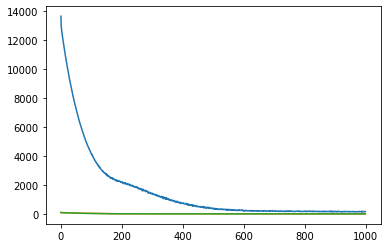

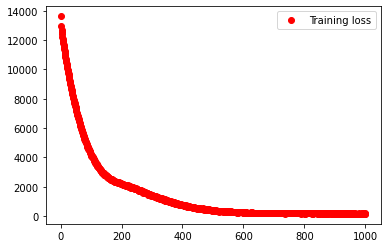

In [153]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
loss = history.history['loss']
acc = history.history['mae']
val_loss = history.history['val_loss']
val_acc = history.history['val_mae']
mape_loss=history.history['mape']
# cosine_los=history.history['cosine_proximity']
pyplot.plot(history.history['mse'])
pyplot.plot(history.history['mae'])
pyplot.plot(history.history['mape'])
# pyplot.plot(history.history['cosine_proximity'])
pyplot.show()
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.legend()
plt.show()

saving the tensorflow hrv prediction model of method 2

In [154]:
tf.keras.models.save_model(regressor1,'hrv_pred_mod2')

INFO:tensorflow:Assets written to: hrv_pred_mod2/assets


INFO:tensorflow:Assets written to: hrv_pred_mod2/assets


Method 3: Reconstruction + Classification prediction

Read data

In [155]:
import glob
import os
import numpy as np
sixhz_signal = list()
twelvehz_signal = list()
labels = list()
sixhzsignal = pd.DataFrame({})
twelvehzsignal = pd.DataFrame({})
labels = list()


folder_path = "/content/drive/MyDrive/SNN_Project/ANN Upsampling Project Data"
all_csvs = glob.glob("/content/drive/MyDrive/SNN_Project/ANN Upsampling Project Data/*.csv") # Read ALL csv files
all_csvs.sort(key=lambda k:int(k.split("/")[-1][-5]))
for i in range(1, 4):
    twelvehz_normal = pd.read_csv(os.path.join(folder_path, f"6hznormal{i}.csv")).transpose()
    sixhz_normal = pd.read_csv(os.path.join(folder_path, f"12hznormal{i}.csv")).transpose()
    twelvehz_abnormal = pd.read_csv(os.path.join(folder_path, f"6hzabnormal{i}.csv")).transpose()
    sixhz_abnormal = pd.read_csv(os.path.join(folder_path, f"12hzabnormal{i}.csv")).transpose()
    if twelvehz_normal.shape[0] < sixhz_normal.shape[0]:
        sixhz_normal = sixhz_normal.iloc[0: twelvehz_normal.shape[0]]
    else:
        twelvehz_normal = twelvehz_normal.iloc[0: sixhz_normal.shape[0]]

    if twelvehz_abnormal.shape[0] < sixhz_abnormal.shape[0]:
        sixhz_abnormal = sixhz_abnormal.iloc[0: twelvehz_abnormal.shape[0]]
    else:
        twelvehz_abnormal = twelvehz_abnormal.iloc[0: sixhz_abnormal.shape[0]]
    if i == 1:
        sixhz_abnormal = sixhz_abnormal.iloc[0:0]
        twelvehz_abnormal = twelvehz_abnormal.iloc[0:0]
    twelvehzsignal = pd.concat([twelvehzsignal, sixhz_normal, sixhz_abnormal])
    sixhzsignal = pd.concat([sixhzsignal, twelvehz_normal, twelvehz_abnormal])
    labels.extend([1] * sixhz_normal.shape[0])
    labels.extend([0] * sixhz_abnormal.shape[0])
input_signal = sixhzsignal.to_numpy()
output_signal = twelvehzsignal.to_numpy()
labels = np.array(labels)
print(f"Abnormal Signals - {np.sum(labels==0)}")
print(f"Normal Signals - {np.sum(labels==1)}")

print(input_signal.shape, output_signal.shape, labels.shape)

Abnormal Signals - 165
Normal Signals - 874
(1039, 113) (1039, 52) (1039,)


In [156]:
output_signal

array([[0.86951 , 0.29245 , 0.38764 , ..., 0.53023 , 0.53743 , 0.66586 ],
       [0.83901 , 0.88518 , 0.97804 , ..., 0.13023 , 0.34998 , 0.40375 ],
       [0.70573 , 0.86419 , 0.12126 , ..., 0.24034 , 0.44883 , 0.64288 ],
       ...,
       [0.12684 , 0.17077 , 0.42114 , ..., 0.56899 , 0.030999, 0.097349],
       [0.12684 , 0.17077 , 0.42114 , ..., 0.56899 , 0.030999, 0.097349],
       [0.12684 , 0.17077 , 0.42114 , ..., 0.56899 , 0.030999, 0.097349]])

for abnormal/normal classifer, we use original 12hz data

In [157]:
# get_input = lambda x: np.array([ann_upsampler(inp.float()).detach().numpy() for inp, op, label in x])
# get_label = lambda x: np.array([label for inp, op, label in x])
from sklearn.model_selection import train_test_split
train_input, test_input, train_labels, test_labels = train_test_split(output_signal, labels, test_size=0.33, random_state=42)
# train_input = get_input(train_set)
# train_labels = get_label(train_set)
# test_input = get_input(test_set)
# test_labels = get_label(test_set)
print(f"Train Abormal Signals - {np.sum(train_labels==0)}")
print(f"Train Normal Signals - {np.sum(train_labels==1)}")

print(f"Test Abormal Signals - {np.sum(test_labels==0)}")
print(f"Test Normal Signals - {np.sum(test_labels==1)}") 

Train Abormal Signals - 113
Train Normal Signals - 583
Test Abormal Signals - 52
Test Normal Signals - 291


In [ ]:
#Now, all the signals mentioned below are 12Hz reconstructed ones (obtained from the prediction of ANNsampler) 
#0-Normal and 1=Abnormal
test_input
test_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier 

1)Support Vector Classifier

In [ ]:
clf_svc = SVC()
clf_svc.fit(train_input, train_labels)

SVC()

In [ ]:
print((clf_svc.predict(test_input) == test_labels).mean())
p=clf_svc.predict(test_input)
res=[]
for i in range(test_input.shape[0]):
  if(p[i]==test_labels[i]):
    res.append(test_input[i])
D=pd.DataFrame(np.row_stack(res))
D

0.9854227405247813


,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,0.177500,0.158680,0.348310,0.61851,0.074224,0.04251,0.106110,0.121620,0.255250,0.357730,...,0.083777,0.121170,0.138500,0.372730,0.585690,0.014147,0.061876,0.10633,0.151330,0.013770
1,0.295880,0.581960,0.743910,0.24542,0.049641,0.29573,0.328550,0.414540,0.704190,0.897230,...,0.498920,0.660060,0.779680,0.387710,0.053044,0.588160,0.767090,0.59688,0.006586,0.203640
2,0.116040,0.281350,0.497120,0.68799,0.074224,0.04251,0.106110,0.121620,0.255250,0.357730,...,0.083777,0.121170,0.138500,0.372730,0.585690,0.014147,0.061876,0.10633,0.151330,0.013770
3,0.882150,0.211500,0.341460,0.35891,0.472210,0.63284,0.723610,0.898480,0.923810,0.154820,...,0.577580,0.706610,0.792120,0.657960,0.188250,0.107860,0.299240,0.41495,0.554330,0.705820
4,0.360300,0.504820,0.649520,0.65161,0.065473,0.16357,0.351630,0.373310,0.574270,0.736090,...,0.806310,0.993590,0.065755,0.097806,0.351030,0.000000,0.089680,0.26877,0.248330,0.487770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,0.374720,0.464780,0.699860,0.84168,0.432580,0.05836,0.312660,0.351560,0.447360,0.620750,...,0.073028,0.002185,0.061197,0.090492,0.139990,0.181950,0.442620,0.51236,0.841880,0.959750
334,0.724050,0.438100,0.003962,0.21608,0.240510,0.32059,0.558920,0.720880,0.854170,0.024287,...,0.043269,0.241610,0.171090,0.408220,0.645870,0.000000,0.143470,0.39853,0.583390,0.777550
335,0.144300,0.170200,0.048638,0.11871,0.226920,0.49311,0.718820,0.737470,0.120900,0.153990,...,0.154110,0.006612,0.075923,0.097289,0.116480,0.563490,0.691900,0.84675,0.751050,0.045467
336,0.074282,0.063632,0.158990,0.21861,0.329060,0.15372,0.001363,0.077082,0.069014,0.162090,...,0.229000,0.454440,0.659680,0.863320,0.877280,0.000000,0.000000,0.00000,0.000000,0.000000


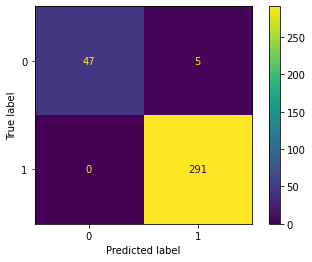

In [ ]:
cm = confusion_matrix(test_labels, clf_svc.predict(test_input))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf_svc.classes_)
disp.plot()
plt.show()

Plot correctly and incorrectly classified signals

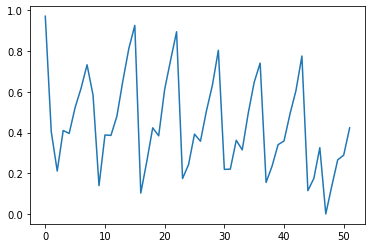

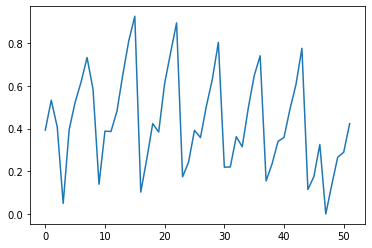

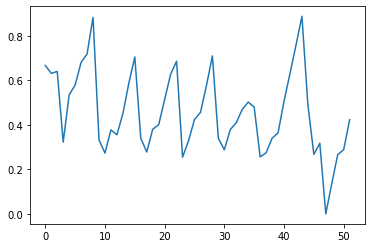

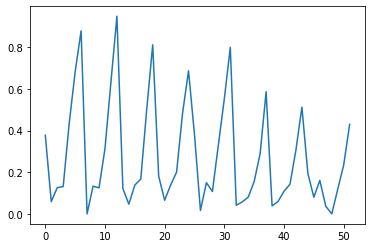

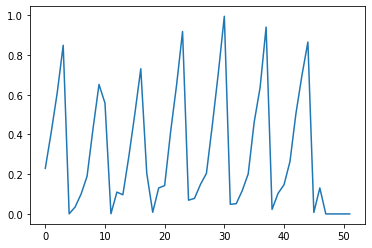

5


In [ ]:
c=0
test_input[(test_labels == clf_svc.predict(test_input))]
for signal in test_input[(test_labels != clf_svc.predict(test_input))]:
    c+=1
    plt.plot(range(0, signal.shape[0]), signal)
    plt.show()
print(c)

Neural Network

In [ ]:
clf_mlp = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=[1000, 500], alpha=0.01).fit(train_input, train_labels)

In [ ]:
print((clf_mlp.predict(test_input) == test_labels).mean())

0.9825072886297376


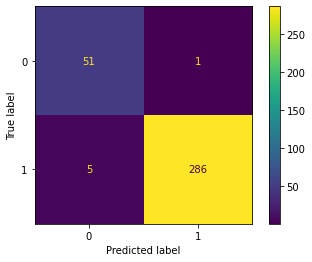

In [ ]:
cm = confusion_matrix(test_labels, clf_mlp.predict(test_input))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf_mlp.classes_)
disp.plot()
plt.show()

Logistic Regression

In [ ]:
clf = LogisticRegression()
clf.fit(train_input, train_labels)

LogisticRegression()

In [ ]:
print((clf.predict(test_input) == test_labels).mean()) 

0.9358600583090378


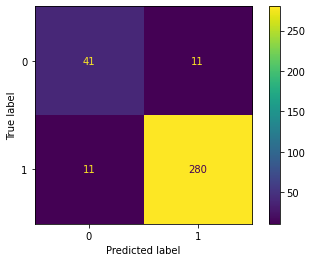

In [ ]:
cm = confusion_matrix(test_labels, clf.predict(test_input))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

evaluating on reconstructed signal

In [ ]:
import pandas as pd
import numpy as np
from numpy import mean 
D=pd.read_csv('12hz_reconst.csv',header=None) 
pred=clf_svc.predict(D)
res=[]
for i in range(D.shape[0]):
  if(pred[i]==1):
    res.append(D.iloc[i,:].values)
f=pd.DataFrame(res,columns=[i for i in range(0,52)])
f

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,0.195756,0.282575,0.446329,0.656743,0.375785,0.591294,0.699244,0.832127,0.762141,0.082253,...,0.713542,0.868933,0.666879,0.113859,0.340849,-0.003828,0.141098,0.213495,0.381525,0.659503
1,0.215893,0.372213,0.533615,0.668788,0.041478,0.016265,0.175464,0.177058,0.344453,0.528187,...,0.154902,0.047397,0.225379,0.212217,0.453528,0.391836,0.554095,0.288292,0.019058,0.157460
2,0.202112,0.372789,0.512991,0.689685,0.920728,0.376402,-0.001855,0.109301,0.173437,0.291926,...,0.825026,0.957964,0.089023,0.053547,0.255348,0.083941,0.048220,0.189712,0.225961,0.390109
3,0.703870,0.903575,0.224795,0.043692,0.296731,0.238838,0.354692,0.564138,0.770228,0.203647,...,0.342423,0.583195,0.853882,0.165191,0.028089,0.378951,0.012719,0.149354,0.177704,0.217407
4,0.164691,0.473160,0.604114,0.712014,0.642083,0.782224,0.723039,0.111469,0.384548,0.376732,...,0.171441,0.446415,0.710116,0.252330,0.142314,0.174186,0.184577,0.333027,0.502527,0.691656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,0.334352,0.171361,0.253592,0.228858,0.363861,0.536010,0.735442,0.538297,0.096858,0.212025,...,0.610401,0.787021,0.963071,0.243007,0.100404,0.000617,0.136052,0.160725,0.375988,0.608334
883,0.195561,0.361920,0.466903,0.614139,0.841808,0.022798,0.067269,0.234260,0.278282,0.472232,...,0.019125,0.190220,0.207487,0.318803,0.532806,0.330500,0.547672,0.746247,0.543156,0.034660
884,0.090031,0.226135,0.425340,0.493503,0.437378,0.599347,0.745336,0.850754,0.122747,0.065080,...,0.366201,0.010326,0.131451,0.226532,0.321366,0.018249,0.147378,0.261797,0.292479,0.420556
885,0.256748,0.548577,0.613865,0.753010,0.280458,0.135931,0.357092,0.328331,0.623281,0.746483,...,0.830517,0.790791,-0.014445,0.238860,0.404494,0.002477,0.017920,0.281145,0.508473,0.751371


In [ ]:
887/1039

0.8537054860442733

out of 1039 reconstructed signals, 887 are normal ones. so ratio is 887/1039= 85% signal is normal

In [ ]:
f.to_csv('svc_12.csv',index=False,header=False)
#saving classifier model for quick use
# save the model to disk
import pickle
filename = 'svc_model.sav'
pickle.dump(clf_svc, open(filename, 'wb'))
# some time later... 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model
# result = loaded_model.score(X_test, Y_test)
# print(result)

SVC()

ground truths (heart rate)

In [ ]:
import torch
import glob2
import pandas as pd
import os
import heartpy as hp
HR=[]
D=pd.read_csv('svc_12.csv',header=None)
for i in range(0,D.shape[0]):
  working_data,measures=hp.process(D.iloc[i,:].values,12,calc_freq=True)
  HR.append(measures['bpm'])
len(HR)
Output_HR=pd.DataFrame(HR)
Output_HR.to_csv('12_svc_gt.csv',index=False,header=False)

/usr/local/lib/python3.7/dist-packages/heartpy/analysis.py:522: UserWarning: Short signal.

---------Warning:---------
too few peak-peak intervals for (reliable) frequency domain measure computation, frequency output measures are still computed but treat them with caution!

HF is usually computed over a minimum of 1 minute of good signal. LF is usually computed over a minimum of 2 minutes of good signal.VLF is usually computed over a minimum of 5 minutes of good signal.The LF/HF ratio is usually computed over minimum 24 hours, although an absolute minimum of 5 min has also been suggested.

For more info see: 
Shaffer, F., Ginsberg, J.P. (2017), An Overview of Heart Rate Variability Metrics and Norms.

Task Force of Pacing and Electrophysiology (1996), Heart Rate Variability, in: European Heart Journal, vol.17, issue 3, pp354-381

This warning will not repeat
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/numpy/ma/core.py:5244: RuntimeWarning: Mean of empty sli

prediction

Case-1: using original 12hz trained model

In [ ]:
from tensorflow.keras.models import load_model

In [144]:
m1=tf.keras.models.load_model('hrv_pred_mod1', custom_objects={'sine':sine})
m1.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sinusodial_representation_d  (None, 53)               2809      
 ense_36 (SinusodialRepresen                                     
 tationDense)                                                    
                                                                 
 dropout_38 (Dropout)        (None, 53)                0         
                                                                 
 sinusodial_representation_d  (None, 25)               1350      
 ense_37 (SinusodialRepresen                                     
 tationDense)                                                    
                                                                 
 dropout_39 (Dropout)        (None, 25)                0         
                                                                 
 dense_24 (Dense)            (None, 1)               

In [145]:
import pandas as pd
import numpy as np
from numpy import mean 
D=pd.read_csv('svc_12.csv',header=None)
Y=pd.read_csv('12_svc_gt.csv',header=None)
Y[0].fillna(value=Y[0].mean(), inplace=True)
from sklearn.model_selection import train_test_split
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(D, Y, test_size = 0.2, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(D, Y, test_size = 0.2, random_state = 0)
X_train 

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
363,0.191439,0.259478,0.362350,0.482871,0.584270,0.051101,0.022698,0.189814,0.164032,0.344476,...,0.107064,0.016097,0.243844,0.231413,0.460230,-0.004278,0.167113,0.441538,0.725245,0.831833
255,0.801549,0.806861,0.045961,0.124505,0.303492,0.273387,0.612524,0.855983,0.477099,0.046670,...,0.794223,0.084235,0.175819,0.403752,0.258187,0.099644,0.154188,0.494664,0.838882,0.669611
476,0.175478,0.131585,0.101100,0.209234,0.494725,0.765016,0.352808,0.250705,0.373528,0.305888,...,0.076527,0.065136,0.195894,0.166507,0.295502,0.564426,0.701414,0.864545,0.575345,0.113699
271,0.381146,0.590971,0.742267,0.784335,0.861126,0.228547,0.291122,0.397521,0.567714,0.677800,...,0.105921,0.040843,0.147305,0.162447,0.179551,0.330233,0.025762,0.142548,0.219292,0.397258
553,0.231739,0.375171,0.491436,0.671870,0.921039,0.069363,0.029416,0.229625,0.277302,0.469349,...,-0.005464,0.170061,0.258581,0.361962,0.587930,0.388932,0.615133,0.837327,0.816816,0.028537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,0.349816,0.551506,0.732792,0.825959,0.164598,0.107877,0.263802,0.259271,0.413047,0.559583,...,0.081975,0.161187,0.176982,0.310426,0.447614,0.464410,0.609623,0.710622,0.820153,0.738889
192,0.192412,0.182041,0.310628,0.353348,0.583289,0.752313,0.833633,0.579184,0.085789,0.111769,...,0.819420,0.596569,0.150564,0.377353,0.408329,0.411282,0.565345,0.832790,0.879537,0.998749
629,0.379206,0.535964,0.151306,0.035671,0.203611,0.212598,0.393828,0.528570,0.238324,0.033650,...,0.304078,0.501070,0.722531,0.910895,0.448120,0.403396,0.603566,0.838150,0.809486,-0.012221
559,0.711653,0.627254,0.334563,0.273256,0.822562,0.872743,0.360657,0.051093,0.349737,0.339210,...,0.472512,0.517308,0.668764,0.069357,0.209744,0.956403,0.403899,0.351508,0.480287,0.443370


In [146]:
pred=m1.predict(D)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
mse=mean_squared_error(Y,pred)
mae= mean_absolute_error(Y,pred)
print(f"mse is:{mse},mae is:{mae}")

mse is:284.2667215730085,mae is:9.533944607899429


Case-2: training on reconstructed signal 

In [158]:
from tensorflow.keras.models import load_model
m2=tf.keras.models.load_model('hrv_pred_mod2', custom_objects={'sine':sine})
m2.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sinusodial_representation_d  (None, 53)               2809      
 ense_38 (SinusodialRepresen                                     
 tationDense)                                                    
                                                                 
 dropout_40 (Dropout)        (None, 53)                0         
                                                                 
 sinusodial_representation_d  (None, 25)               1350      
 ense_39 (SinusodialRepresen                                     
 tationDense)                                                    
                                                                 
 dropout_41 (Dropout)        (None, 25)                0         
                                                                 
 dense_25 (Dense)            (None, 1)               

In [159]:
pred=m2.predict(D)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
mse=mean_squared_error(Y,pred)
mae= mean_absolute_error(Y,pred)
print(f"mse is:{mse},mae is:{mae}")

mse is:78.79625920311324,mae is:5.33396545630694


Case3: training on Classified signal and testing 

In [160]:
import pandas as pd
import numpy as np
from numpy import mean 
D=pd.read_csv('svc_12.csv',header=None)
Y=pd.read_csv('12_svc_gt.csv',header=None)
Y[0].fillna(value=Y[0].mean(), inplace=True)
from sklearn.model_selection import train_test_split
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(D, Y, test_size = 0.2, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(D, Y, test_size = 0.2, random_state = 0)
X_train 

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
363,0.191439,0.259478,0.362350,0.482871,0.584270,0.051101,0.022698,0.189814,0.164032,0.344476,...,0.107064,0.016097,0.243844,0.231413,0.460230,-0.004278,0.167113,0.441538,0.725245,0.831833
255,0.801549,0.806861,0.045961,0.124505,0.303492,0.273387,0.612524,0.855983,0.477099,0.046670,...,0.794223,0.084235,0.175819,0.403752,0.258187,0.099644,0.154188,0.494664,0.838882,0.669611
476,0.175478,0.131585,0.101100,0.209234,0.494725,0.765016,0.352808,0.250705,0.373528,0.305888,...,0.076527,0.065136,0.195894,0.166507,0.295502,0.564426,0.701414,0.864545,0.575345,0.113699
271,0.381146,0.590971,0.742267,0.784335,0.861126,0.228547,0.291122,0.397521,0.567714,0.677800,...,0.105921,0.040843,0.147305,0.162447,0.179551,0.330233,0.025762,0.142548,0.219292,0.397258
553,0.231739,0.375171,0.491436,0.671870,0.921039,0.069363,0.029416,0.229625,0.277302,0.469349,...,-0.005464,0.170061,0.258581,0.361962,0.587930,0.388932,0.615133,0.837327,0.816816,0.028537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,0.349816,0.551506,0.732792,0.825959,0.164598,0.107877,0.263802,0.259271,0.413047,0.559583,...,0.081975,0.161187,0.176982,0.310426,0.447614,0.464410,0.609623,0.710622,0.820153,0.738889
192,0.192412,0.182041,0.310628,0.353348,0.583289,0.752313,0.833633,0.579184,0.085789,0.111769,...,0.819420,0.596569,0.150564,0.377353,0.408329,0.411282,0.565345,0.832790,0.879537,0.998749
629,0.379206,0.535964,0.151306,0.035671,0.203611,0.212598,0.393828,0.528570,0.238324,0.033650,...,0.304078,0.501070,0.722531,0.910895,0.448120,0.403396,0.603566,0.838150,0.809486,-0.012221
559,0.711653,0.627254,0.334563,0.273256,0.822562,0.872743,0.360657,0.051093,0.349737,0.339210,...,0.472512,0.517308,0.668764,0.069357,0.209744,0.956403,0.403899,0.351508,0.480287,0.443370


In [161]:
#using reconstructed signal (12Hz )
from tf_siren import SinusodialRepresentationDense
from tf_siren import SIRENModel
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation
def sine(x):
    return tf.math.sin(x)
get_custom_objects().update({'sine':Activation(sine)})
regressor1 = Sequential()
regressor1.add(SinusodialRepresentationDense(53,input_dim=X_train.shape[1], kernel_initializer='he_uniform',activation='sine',kernel_regularizer=l2(0.01),activity_regularizer=l2(0.01)))
regressor1.add(Dropout(0.1))
regressor1.add(SinusodialRepresentationDense(25, kernel_initializer='he_uniform',activation='sine'))
regressor1.add(Dropout(0.1))
regressor1.add(Dense(1, kernel_initializer='he_uniform',activation='linear'))

In [162]:
 # reconstructed signal(12 hz)
import numpy as np
import matplotlib.pyplot as plt 
from scipy.signal import find_peaks
regressor1.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam',metrics=['mae','mse','mape'])
# Fitting the ANN to the Training set
history=regressor1.fit(X_train, y_train,validation_data=(X_val, y_val) ,batch_size = 32, epochs = 1000)
test_loss = regressor1.evaluate(X_test,y_test)

Epoch 1/1000
23/23 [==============================] - 2s 21ms/step - loss: 9227.9111 - mae: 94.2637 - mse: 9226.7178 - mape: 97.1769 - val_loss: 8586.0361 - val_mae: 91.1804 - val_mse: 8584.8135 - val_mape: 94.6684
Epoch 2/1000
23/23 [==============================] - 0s 5ms/step - loss: 8693.4580 - mae: 91.3830 - mse: 8692.2100 - mape: 94.0667 - val_loss: 8299.7012 - val_mae: 89.5979 - val_mse: 8298.4414 - val_mape: 92.9628
Epoch 3/1000
23/23 [==============================] - 0s 5ms/step - loss: 8511.2881 - mae: 90.3829 - mse: 8510.0244 - mape: 92.9877 - val_loss: 8159.7617 - val_mae: 88.8152 - val_mse: 8158.5020 - val_mape: 92.1188
Epoch 4/1000
23/23 [==============================] - 0s 6ms/step - loss: 8375.1865 - mae: 89.6260 - mse: 8373.9277 - mape: 92.1784 - val_loss: 8034.8237 - val_mae: 88.1083 - val_mse: 8033.5767 - val_mape: 91.3535
Epoch 5/1000
23/23 [==============================] - 0s 6ms/step - loss: 8253.0430 - mae: 88.9396 - mse: 8251.8008 - mape: 91.4307 - val_loss:

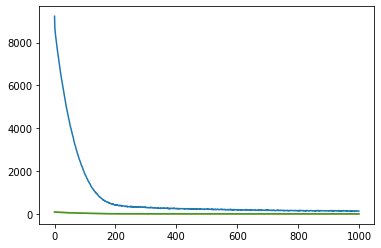

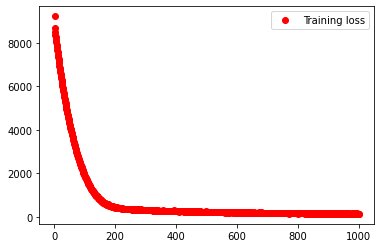

In [163]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
loss = history.history['loss']
acc = history.history['mae']
val_loss = history.history['val_loss']
val_acc = history.history['val_mae']
mape_loss=history.history['mape']
# cosine_los=history.history['cosine_proximity']
pyplot.plot(history.history['mse'])
pyplot.plot(history.history['mae'])
pyplot.plot(history.history['mape'])
# pyplot.plot(history.history['cosine_proximity'])
pyplot.show()
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.legend()
plt.show()

In [164]:
tf.keras.models.save_model(regressor1,'hrv_pred_mod3')

INFO:tensorflow:Assets written to: hrv_pred_mod3/assets


INFO:tensorflow:Assets written to: hrv_pred_mod3/assets


Evalution on output signal of classifier model

In [165]:
from tensorflow.keras.models import load_model
m3=tf.keras.models.load_model('hrv_pred_mod3', custom_objects={'sine':sine})
m3.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sinusodial_representation_d  (None, 53)               2809      
 ense_40 (SinusodialRepresen                                     
 tationDense)                                                    
                                                                 
 dropout_42 (Dropout)        (None, 53)                0         
                                                                 
 sinusodial_representation_d  (None, 25)               1350      
 ense_41 (SinusodialRepresen                                     
 tationDense)                                                    
                                                                 
 dropout_43 (Dropout)        (None, 25)                0         
                                                                 
 dense_26 (Dense)            (None, 1)               

In [166]:
pred=m3.predict(D)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
mse=mean_squared_error(Y,pred)
mae= mean_absolute_error(Y,pred)
print(f"mse is:{mse},mae is:{mae}")

mse is:94.90378556675968,mae is:5.422994088891853
